# User agent rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 30

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct user agent to device matrix

In [6]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,simon-macpro,MalcomWare-PC,boundless-mac,languid-mac,mark-mac,traverses-mac,rarb-mac,calcannea-cb,terrestrial-mac,theatergoing-mac,...,nervings-cb,DESKTOP-PIMD8C0,serotinal-mac,abroad-android,daniel-chromebook,minesweepers-mac,turing-minimacbook,misskitty-mac,dramatic-mac,score
Software%20Update (unknown ver,12,0,40,1,2,10,7,0,0,2,...,0,0,6,0,0,6,0,4,10,119
(null)/(null) (Macintosh; OS X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
Microsoft-CryptoAPI/6.1,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
Roblox/199282 CFNetwork/897.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
Roblox/208519 CFNetwork/897.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
Spotify/107700338 (9; 0; 2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,8
Safari/13605.2.8 CFNetwork/901,0,0,0,0,0,0,0,0,230,0,...,0,0,0,0,0,0,0,0,0,230
Mozilla/5.0 (Macintosh; Intel,405,0,32337,2548,1210,7,98,0,8058,135,...,0,0,3735,0,0,2551,833,8556,22850,87753
Mozilla/5.0 (X11; Ubuntu; Linu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4361
Mozilla/5.0 (Windows NT 6.1; W,0,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14


## Get list of highest accessed user agents by all devices

In [7]:
top_uas = df.sort_values(by="score", ascending=False).index.values[:n]
top_uas

array(['Mozilla/5.0 (Macintosh; Intel ', 'Roblox/Darwin',
       'Mozilla/5.0 (X11; CrOS x86_64 ', 'Microsoft-Delivery-Optimizatio',
       'Mozilla/5.0 EA Download Manage', 'ProtoHttp 1.3/DS 15.1.2.3.0 (A',
       'python-requests/2.13.0', 'Mozilla/5.0 (X11; Ubuntu; Linu',
       'trustd (unknown version) CFNet', 'Mozilla/5.0 (Linux; Android 6.',
       'Mozilla/5.0 (Windows NT 10.0; ', 'Microsoft-WNS/10.0',
       'Debian APT-HTTP/1.3 (1.2.26)', 'MICROSOFT_DEVICE_METADATA_RETR',
       'ClamAV/0.100.0 (OS: darwin17.5', 'Mozilla/5.0 (Windows NT 6.1) A',
       'Microsoft-CryptoAPI/10.0', 'Safari/13605.2.8 CFNetwork/901',
       'Microsoft BITS/7.8', 'Windows-Update-Agent/10.0.1001',
       'server-bag [Mac OS X,10.13.5,1', 'dnf/2.7.5',
       'MacAppStore/2.4 (Macintosh; OS', 'Mac OS X/10.12.6 (16G1408)',
       'Microsoft BITS/7.5', 'server-bag [Mac OS X,10.12.6,1',
       'Dalvik/2.1.0 (Linux; U; Androi', 'Software%20Update (unknown ver',
       'Mac OS X/10.13.5 (17F77)', 'Microsof

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [9]:
fav_uas = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_uas

[['simon-macpro',
  array(['Mozilla/5.0 (Macintosh; Intel ', 'trustd (unknown version) CFNet',
         'MacAppStore/2.4 (Macintosh; OS', 'server-bag [Mac OS X,10.13.5,1',
         'server-bag [Mac OS X,10.13.4,1', 'Mac OS X/10.13.4 (17E199)',
         'Software%20Update (unknown ver', 'Mac OS X/10.13.5 (17F77)',
         'com.apple.trustd/1.0', 'GoogleSoftwareUpdate/1.2.10.10',
         'mobileassetd (unknown version)', 'Adobe GC 1.0',
         'Mozilla/5.0 (Windows NT 6.1) A', 'Mozilla/4.0 (compatible; MSIE ',
         'git/2.14.4', 'Mozilla/5.0 (Linux; Android 6.', 'WicaAgent',
         'Mac OS X/10.13.3 (17D47)', 'GCSL_GCSP 3.06.1.3084',
         'Spotify/107500483 (9; 0; 2)', 'AndroidDownloadManager/8.1.0 (',
         'Mozilla/5.0 (Windows NT 10.0; ', 'amcuninstall/1.0 CFNetwork/897',
         'touristd/1.0.52 CFNetwork/901.', 'ACC_2.00.3024_1D121C0259B2E9EB',
         '"Mozilla/5.0 (iPhone; CPU iPho', 'ACC_2.00.3024_11D6185BEBA45BBE',
         'Spotlight/1075.40 CFNetwork/81', 'd

In [10]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2

,useragents
device,
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
MalcomWare-PC,"[Microsoft BITS/7.5, Mozilla/5.0 (Windows NT 6..."
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (..."
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
traverses-mac,"[trustd (unknown version) CFNet, MacAppStore/2..."
rarb-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (..."
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]

,useragents,coefficient
device,,
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",-2.91
tirasse-mac,"[Mozilla/5.0 (Macintosh; Intel , Mac OS X/10.1...",-2.96
essential-mac,"[trustd (unknown version) CFNet, Spotlight/107...",-3.07
ludicrous-mac,"[Mozilla/5.0 (Macintosh; Intel , server-bag [M...",-3.08
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-3.09
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",-3.16
steamverne-mac,"[Mozilla/5.0 (X11; Ubuntu; Linu, Mozilla/5.0 (...",-3.16
nervings-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",-3.19
daniel-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",-3.19


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: spearman(uas, x)).round(2)

In [14]:
df3

,useragents,simon-macpro,MalcomWare-PC,boundless-mac,languid-mac,mark-mac,traverses-mac,rarb-mac,calcannea-cb,terrestrial-mac,...,elysium-mac,nervings-cb,DESKTOP-PIMD8C0,serotinal-mac,abroad-android,daniel-chromebook,minesweepers-mac,turing-minimacbook,misskitty-mac,dramatic-mac
device,,,,,,,,,,,,,,,,,,,,,
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",1.00,-2.16,-1.34,-2.06,-1.60,-0.82,-1.14,-2.22,-1.62,...,-0.53,-2.22,-2.86,-1.56,-2.01,-2.22,-0.82,-1.35,-2.42,-2.51
MalcomWare-PC,"[Microsoft BITS/7.5, Mozilla/5.0 (Windows NT 6...",-2.16,1.00,-2.96,-2.23,-0.86,-1.25,-1.03,0.03,-1.73,...,-2.49,-0.52,-2.36,-0.66,-0.40,-0.52,-2.13,-1.87,-2.14,-4.38
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (...",-1.34,-2.96,1.00,-3.42,-2.09,-1.66,-2.46,-2.90,-2.47,...,-1.16,-3.20,-3.76,-2.54,-3.10,-3.20,-1.59,-2.62,-2.80,-3.10
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-2.06,-2.23,-3.42,1.00,-1.50,-1.70,-0.68,-1.89,-0.99,...,-2.19,-1.85,-3.59,-1.85,-1.99,-1.85,-2.76,-0.93,-1.69,-2.76
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-1.60,-0.86,-2.09,-1.50,1.00,-0.83,-0.26,-0.85,-1.19,...,-1.43,-0.82,-3.18,-0.58,-0.85,-0.82,-1.72,-1.32,-1.87,-3.62
traverses-mac,"[trustd (unknown version) CFNet, MacAppStore/2...",-0.82,-1.25,-1.66,-1.70,-0.83,1.00,-0.90,-1.53,-1.19,...,-0.86,-1.39,-2.76,-0.93,-1.34,-1.39,-1.60,-1.12,-1.70,-3.19
rarb-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-1.14,-1.03,-2.46,-0.68,-0.26,-0.90,1.00,-0.94,-0.31,...,-1.56,-0.66,-2.85,-0.70,-0.66,-0.66,-1.83,-0.47,-1.31,-3.18
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-2.22,0.03,-2.90,-1.89,-0.85,-1.53,-0.94,1.00,-1.73,...,-2.46,0.36,-2.72,-0.76,0.03,0.36,-2.26,-1.86,-2.26,-3.99
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-1.62,-1.73,-2.47,-0.99,-1.19,-1.19,-0.31,-1.73,1.00,...,-1.89,-1.72,-3.29,-1.38,-1.66,-1.72,-2.33,0.35,-1.27,-3.23


In [15]:
## Don't need to calculate the log.

## Plot heatmap

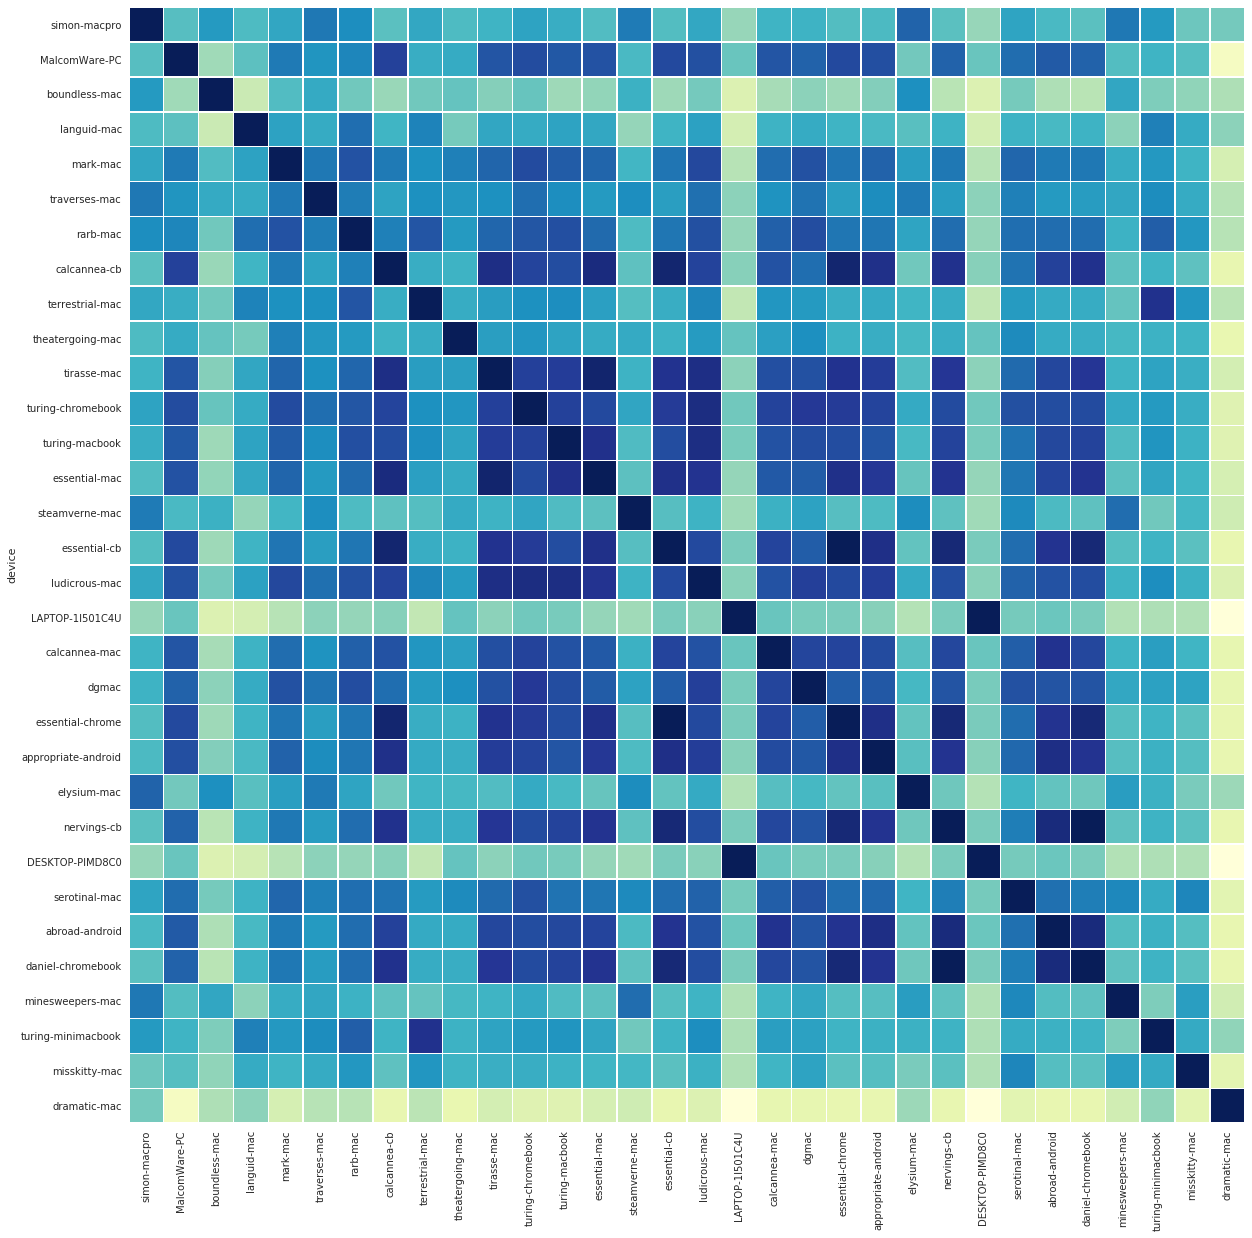

In [16]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()